# A Totural on Binary Estimation 

In this notebook we are going to estimate weights (coefficients) of a linear regression model as binary values. Different scenarios with different methods such as rounded least square, binary penalty, and rounded $L_1$ regularisation have been checked.

# Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_validate
from scipy.stats import norm, multivariate_normal
from sklearn.linear_model import Lasso

# Data Generating

Dataset is generated over a normal distribution with $\mu=0$ and $\Sigma=\textit{I}_{p\times p}$ or
$X \sim \mathcal{N}_{p}(\mu, \Sigma)$.
The output is also generated based on a linear function including a noise term as follows 
\begin{align*}
Y&=X\beta^T+\epsilon \\
\epsilon &\sim \mathcal{N}(0, \sigma^2) \\
\end{align*}

And $\beta$ is the vector of weights.

In [3]:
def DataGenerator(n_samples, n_features, weights=None, noise_variance=0.5, feature_mean = None, feature_cov = None, random_state=None):
    RNG = np.random.default_rng(seed=random_state)

    if weights is None:
       weights = np.squeeze(RNG.multivariate_normal(np.zeros(1), np.eye(1), size=n_features))
    else:
        weights = weights
    
    # n_features = len(weights)

    feature_mean = np.zeros(n_features) if feature_mean is None else feature_mean
    feature_cov = np.eye(n_features) if feature_cov is None else feature_cov
    x = RNG.multivariate_normal(feature_mean, feature_cov, size=n_samples)
    # x = np.hstack((np.ones(shape=(n_samples, 1)), x))

    y = x.dot(weights) + RNG.normal(0, noise_variance, size=n_samples)
    return x, y, weights

# Loss Function: Mean Squared Error

To evaluate the performance of the applied methods we use the mean squared error with following definition

\begin{align*}
MSE&=\frac{1}{2N}\sum_{n=1}^{N}(\hat{y}_n-y_n)^2 \\
\end{align*}

In [4]:
def squared_error(beta, x, y): 
    d = x.shape[1]
    beta = np.reshape(beta,(-1, d))
    return np.sum((beta@x.T-y)**2)/(2*len(x))

# Least Square Estimation

In [5]:
def leastsquare(x, y):
    return np.linalg.solve(x.T.dot(x), x.T.dot(y))

# Optimizer

In [6]:
def minimizer(lossfunction, alpha, x, y):   
    n_features = x.shape[1]
    initial_beta = np.random.randint(2,size=(n_features))
    # initial_beta = np.zeros(n_features)
    # bounds = Bounds(lb=np.zeros(n_features),ub=np.ones(n_features))
    result = minimize(lossfunction, x0=initial_beta, args=(alpha, x, y), method='Powell', options={'ftol':1e-8})
    optimized_beta = result.x
    return optimized_beta

# Binary Estimation

We want to add a regularization (penalty/punishemnt) term $p(\beta)$ to the loss function to sparse the solution space. It would be written as follows

\begin{equation*} 
Regularized\;Loss\;Function = \| X\beta - Y\|_2^2 + P(\beta) 
\end{equation*}

The final goal is to obtain $\beta$ which minimize the regularized loss function. 

\begin{equation*} 
\hat{\beta} = \underset{\beta \in \mathcal{R}^2}{argmin} \; \| X\beta - Y\|_2^2 + \alpha.P(\beta)
\end{equation*}

We consider two different regularisation terms, the Lasso ($L_1$) and binary penalty (W-shape). The Lasso is considered as the first norm of the vector of the weights as below

\begin{equation*} 
P_{Lasso}(\beta) = \alpha \|\beta\| 
\end{equation*}

and the binary penalty term (W-shape) is assumed as a piecewise-componentwise function defined as below

\begin{equation*}
P_{Binary}(\beta) = \sum_{i=0}^{p} \Bigg\{ 
    \begin{array}{rcl}
     |\beta_i| & if & \beta_i \le \frac{1}{2}\\
    |\beta_i-1 | & if & \beta_i > \frac{1}{2}\\
    \end{array}
\end{equation*}

in wich $p$ in number of basis functions. The below plot shows this piecewise function for different values of a single wieght.

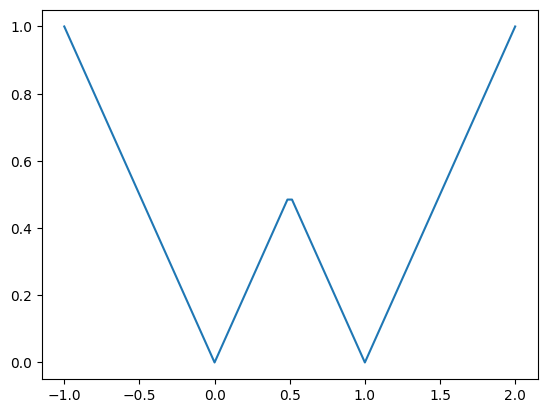

In [7]:
beta_range = np.linspace(-1,2,100)
def binary_type1(b):
    if b<=0.5:
        out = abs(b)
    else:
        out = abs(b-1)
    return out

beta_penalty_type1 = [binary_type1(beta_input) for beta_input in beta_range]
plt.plot(beta_range, beta_penalty_type1)

In [8]:
def binary_lossfunc(beta, alpha , x, y):
  n_features = x.shape[1]
  pp = []
  beta = np.reshape(beta,(-1, n_features))
  for i in range((beta.shape)[0]):
    p = []
    for b in beta[i]:
      if b<=0.5:
        p.append(alpha*abs(b))
      else:
        p.append(alpha*abs(b-1))
    pp.append(np.sum(p))
  return squared_error(beta,x , y)+np.asarray(pp)


def binary_lossfunc_type2(beta, alpha , x, y):
  n_features = x.shape[1]
  pp = []
  beta = np.reshape(beta,(-1, n_features))
  for i in range((beta.shape)[0]):
    p = []
    for b in beta[i]:
      if b<0:
        p.append(b**2)
      if b>1:
        p.append((b-1)**2)
      # if b>=0 and b<=1:
      #   p.append(-8*(b-0.5)**2+2)
      #   # p.append(-4*abs(b-0.5)+2)

      # if b>=0 and b<=0.5:
      #   p.append(0.25/(1+np.exp(-20*(b-0.25))))
      # if b>0.5 and b<=1:
      #   p.append(0.25/(1+np.exp(20*(b-(3/4)))))

      if b>=0 and b<=0.25:
        p.append(2*b**2)
      if b >0.25 and b <(3/4):
        p.append(-2*(b-0.5)**2+0.25)
        # p.append(-0.5*abs(b-0.5)+0.25)
      if b>=(3/4) and b<=1:
        p.append(2*(b-1)**2)
    pp.append(np.sum(p))
  return squared_error(beta,x , y)+alpha*np.asarray(pp)

# Binary Rounding
This function is applied to round the estimated weights into 0 and 1 based on the least distance.

In [16]:
def binary_round(v):
    v = np.asarray(v)
    bv = []
    for x in v:
        if abs(x) < abs(x-1):
            x = 0
        elif abs(x-1) <= abs(x):
            x = 1
        bv.append(x)
    return bv

# Resampling

In [9]:
class Resampling:

    def __init__(self, reps, train_size, random_state=None):
        self.reps = reps
        self.train_size = train_size
        self.RNG = np.random.default_rng(random_state)

    def get_n_splits(self):
        return self.reps

    def split(self, x, y=None, groups=None):
        for _ in range(self.reps):
            train_idx = self.RNG.choice(len(x), size=self.train_size, replace=True)
            test_idx = np.setdiff1d(np.arange(len(x)), train_idx)
            np.random.shuffle(test_idx)
            yield train_idx, test_idx

# Exhaustive Algorithm to find the best binary approximation

As a baseline we want to find the best binary combination as a best binary approximation minimising the loss function. Here we define an exhaustive algorithm to consider all possible binary combinations.

In [9]:
import itertools
def exhaustive_binary(n_answers, x, y):

    all_answer_lst = list(itertools.product([0, 1], repeat=n_answers))
    error = []
    for pa in all_answer_lst:
        error.append(squared_error(np.asarray(pa), x, y))

    error = np.asarray(error)
    best_binary = all_answer_lst[np.argmin(error)]
    return best_binary, np.min(error)

# CV algorithm to search for the best $\alpha$

Since in a regularised loss function, the penalty term should be considered with a specific rate ($\alpha$), we define a cross validation algorithm to find the suitable $\alpha$.

In [10]:
def search_for_alpha(x, y, func, alpha_range, n_folds):
    func_min_test_error, func_alpha = [], []

    if len(x)<n_folds:
        kf = KFold(n_splits=len(x), shuffle=True, random_state=529)
    else:
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=529)

    func_mean_sse_test_per_alpha,func_std_sse_test_per_alpha = [], []

    for a in alpha_range:
        func_beta_hat_per_fold, func_rounded_beta_hat_per_fold, func_sse_test_per_fold = [], [], []
        for train_ind, val_ind in kf.split(x,y):

            if func is Lasso:
                func_beta_hat_per_fold.append(Lasso(alpha=a).fit(x[train_ind], y[train_ind]).coef_)
            else:
                func_beta_hat_per_fold.append(minimizer(func, a, x[train_ind], y[train_ind]))

            func_rounded_beta_hat_per_fold.append(binary_round(func_beta_hat_per_fold[-1]))
            func_sse_test_per_fold.append(squared_error(func_rounded_beta_hat_per_fold[-1], x[val_ind], y[val_ind]))

        func_mean_sse_test_per_alpha.append(np.mean(func_sse_test_per_fold))
    
    func_min_test_error = min(func_mean_sse_test_per_alpha)
    func_alpha = alpha_range[func_mean_sse_test_per_alpha.index(min(func_mean_sse_test_per_alpha))]

    return func_alpha, func_min_test_error


def search_for_alpha_with_outer_cv(x, y, func, alpha_range, n_folds):
    if len(x)<=n_folds:
        func_alpha, func_test_error = search_for_alpha(x, y, func, alpha_range, n_folds) 
    else:
        kf_outer_cv = KFold(n_splits=n_folds, shuffle=True, random_state=529)
        func_alpha_per_fold, func_sse_test_error_per_fold = [], []
        for train_ind_outer, test_ind_outer in kf_outer_cv.split(x,y):
            inner_alpha, inner_error = search_for_alpha(x[train_ind_outer], y[train_ind_outer], func, alpha_range, n_folds)
            if func is Lasso:
                func_beta_hat_per_fold = binary_round(Lasso(alpha=inner_alpha).fit(x[train_ind_outer], y[train_ind_outer]).coef_)
            else:
                func_beta_hat_per_fold = binary_round(minimizer(func, inner_alpha, x[train_ind_outer], y[train_ind_outer]))
            func_sse_test_error_per_fold.append(squared_error(func_beta_hat_per_fold, x[test_ind_outer], y[test_ind_outer]))
            func_alpha_per_fold.append(inner_alpha)
        func_alpha = np.mean(func_alpha_per_fold)
        func_test_error = np.mean(func_sse_test_error_per_fold)
    return func_alpha, func_test_error

# Scenario No. 1: A dataset with binary weights

In the first scenario a dataset with $p=10$ features and $N_{sample}$ sample has been considered. $\beta$ is a vector of 0 and 1: $\beta_i \sim \{1,0\}, \beta = \{\beta_i | i=1,..,p\}$

In [12]:
beta = np.array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1])
xb_test, yb_test, _ = DataGenerator(n_samples=1000, n_features=len(beta), weights=beta, random_state=1)

In [13]:
alpha_range = np.logspace(-3, 0, num=10)
n_folds = 20
n_repitition = 100
sample_size = np.round(100*np.array(np.linspace(0.15,0.4,5))).astype(int)
l1_min_alpha_per_size = []
binary_min_alpha_per_size = []
l1_train_mean_sse_per_size, l1_train_std_sse_per_size, l1_test_mean_sse_per_size, l1_test_std_sse_per_size = [], [], [], []
binary_train_mean_sse_per_size, binary_train_std_sse_per_size, binary_test_mean_sse_per_size, binary_test_std_sse_per_size = [], [], [], []
l1_beta_hat_mean_error_per_size,l1_beta_hat_std_error_per_size, binary_beta_hat_mean_error_per_size, binary_beta_hat_std_error_per_size = [], [], [], []
ls_train_mean_sse_per_size, ls_train_std_sse_per_size, ls_test_mean_sse_per_size, ls_test_std_sse_per_size, ls_beta_hat_mean_error_per_size, ls_beta_hat_std_error_per_size = [], [], [], [], [], []
rls_train_mean_sse_per_size, rls_train_std_sse_per_size, rls_test_mean_sse_per_size, rls_test_std_sse_per_size, rls_beta_hat_mean_error_per_size, rls_beta_hat_std_error_per_size = [], [], [], [], [], []
best_binary_mean_train_sse_per_size,best_binary_std_train_sse_per_size, best_binary_beta_hat_mean_error_per_size, best_binary_beta_hat_std_error_per_size = [], [], [], []
best_binary_mean_test_sse_per_size, best_binary_std_test_sse_per_size = [], []


for ss in sample_size:

    # estimating the best alpha
    xb_selected, yb_selected, _ = DataGenerator(n_samples=ss, n_features=len(beta), weights=beta, random_state=None)
    # l1_min_alpha, l1_min_sse_valid, l1_mean_sse_valid = search_for_alpha(xb_selected, yb_selected, Lasso, alpha_range, n_folds)
    l1_min_alpha, _ = search_for_alpha_with_outer_cv(xb_selected, yb_selected, Lasso, alpha_range, n_folds)
    l1_min_alpha_per_size.append(l1_min_alpha)

    # binary_min_alpha, binary_min_sse_valid, binary_mean_sse_valid = search_for_alpha(xb_selected, yb_selected, binary_lossfunc, alpha_range, n_folds)
    binary_min_alpha, _ = search_for_alpha_with_outer_cv(xb_selected, yb_selected, binary_lossfunc, alpha_range, n_folds)
    binary_min_alpha_per_size.append(binary_min_alpha)

    # estimating the beta in iterations
    l1_beta_hat_per_iter, l1_rounded_beta_hat_per_iter, l1_train_sse_per_iter, l1_test_sse_per_iter = [], [], [], []
    binary_beta_hat_per_iter, binary_rounded_beta_hat_per_iter, binary_train_sse_per_iter, binary_test_sse_per_iter = [], [], [], []
    ls_beta_hat_per_iter, ls_train_sse_per_iter, ls_test_sse_per_iter = [], [], []
    rls_beta_hat_per_iter,rls_train_sse_per_iter,rls_test_sse_per_iter = [], [], []
    best_binary_train_sse_per_iter, best_binary_beta_hat_per_iter, best_binary_test_sse_per_iter = [], [], []
    for rep in range(n_repitition):

        xb_selected, yb_selected, _ = DataGenerator(n_samples=ss, n_features=len(beta), weights=beta, random_state=None)

        l1_beta_hat_per_iter.append(Lasso(l1_min_alpha).fit(xb_selected, yb_selected).coef_)
        l1_rounded_beta_hat_per_iter.append(binary_round(l1_beta_hat_per_iter[-1]))
        l1_train_sse_per_iter.append(squared_error(binary_round(l1_beta_hat_per_iter[-1]),xb_selected, yb_selected))
        l1_test_sse_per_iter.append(squared_error(binary_round(l1_beta_hat_per_iter[-1]),xb_test, yb_test))

        binary_beta_hat_per_iter.append(minimizer(binary_lossfunc, alpha=binary_min_alpha, x=xb_selected, y=yb_selected))
        binary_rounded_beta_hat_per_iter.append(binary_round(binary_beta_hat_per_iter[-1]))
        binary_train_sse_per_iter.append(squared_error(binary_round(binary_beta_hat_per_iter[-1]),xb_selected, yb_selected))
        binary_test_sse_per_iter.append(squared_error(binary_round(binary_beta_hat_per_iter[-1]),xb_test, yb_test))

        ls_beta_hat_per_iter.append(leastsquare(xb_selected, yb_selected))
        ls_train_sse_per_iter.append(squared_error(ls_beta_hat_per_iter[-1], xb_selected, yb_selected))
        ls_test_sse_per_iter.append(squared_error(ls_beta_hat_per_iter[-1], xb_test, yb_test))

        rls_beta_hat_per_iter.append(binary_round(ls_beta_hat_per_iter[-1]))
        rls_train_sse_per_iter.append(squared_error(rls_beta_hat_per_iter[-1], xb_selected, yb_selected))
        rls_test_sse_per_iter.append(squared_error(rls_beta_hat_per_iter[-1], xb_test, yb_test))

        best_binary_answer, best_binary_train_error = exhaustive_binary(n_answers=10, x=xb_selected, y=yb_selected)
        best_binary_train_sse_per_iter.append(best_binary_train_error)
        best_binary_beta_hat_per_iter.append(best_binary_answer)
        best_binary_test_sse_per_iter.append(squared_error(best_binary_answer, xb_test, yb_test))

    l1_train_mean_sse_per_size.append(np.mean(l1_train_sse_per_iter))
    l1_train_std_sse_per_size.append(np.std(l1_train_sse_per_iter))
    l1_test_mean_sse_per_size.append(np.mean(l1_test_sse_per_iter))
    l1_test_std_sse_per_size.append(np.std(l1_test_sse_per_iter))
    l1_beta_hat_mean_error_per_size.append(np.mean(np.sum((beta-l1_rounded_beta_hat_per_iter)**2, axis=1)))
    l1_beta_hat_std_error_per_size.append(np.std(np.sum((beta-l1_rounded_beta_hat_per_iter)**2, axis=1)))

    binary_train_mean_sse_per_size.append(np.mean(binary_train_sse_per_iter))
    binary_train_std_sse_per_size.append(np.std(binary_train_sse_per_iter))
    binary_test_mean_sse_per_size.append(np.mean(binary_test_sse_per_iter))
    binary_test_std_sse_per_size.append(np.std(binary_test_sse_per_iter))
    binary_beta_hat_mean_error_per_size.append(np.mean(np.sum((beta-binary_rounded_beta_hat_per_iter)**2, axis=1)))
    binary_beta_hat_std_error_per_size.append(np.std(np.sum((beta-binary_rounded_beta_hat_per_iter)**2, axis=1)))

    ls_train_mean_sse_per_size.append(np.mean(ls_train_sse_per_iter))
    ls_train_std_sse_per_size.append(np.std(ls_train_sse_per_iter))
    ls_test_mean_sse_per_size.append(np.mean(ls_test_sse_per_iter))
    ls_test_std_sse_per_size.append(np.std(ls_test_sse_per_iter))
    ls_beta_hat_mean_error_per_size.append(np.mean(np.sum((beta-ls_beta_hat_per_iter)**2, axis=1)))
    ls_beta_hat_std_error_per_size.append(np.std(np.sum((beta-ls_beta_hat_per_iter)**2, axis=1)))

    rls_train_mean_sse_per_size.append(np.mean(rls_train_sse_per_iter))
    rls_train_std_sse_per_size.append(np.std(rls_train_sse_per_iter))
    rls_test_mean_sse_per_size.append(np.mean(rls_test_sse_per_iter))
    rls_test_std_sse_per_size.append(np.std(rls_test_sse_per_iter))
    rls_beta_hat_mean_error_per_size.append(np.mean(np.sum((beta-rls_beta_hat_per_iter)**2, axis=1)))
    rls_beta_hat_std_error_per_size.append(np.std(np.sum((beta-rls_beta_hat_per_iter)**2, axis=1)))

    best_binary_mean_train_sse_per_size.append(np.mean(best_binary_train_sse_per_iter))
    best_binary_std_train_sse_per_size.append(np.std(best_binary_train_sse_per_iter))
    best_binary_mean_test_sse_per_size.append(np.mean(best_binary_test_sse_per_iter))
    best_binary_std_test_sse_per_size.append(np.std(best_binary_test_sse_per_iter))
    best_binary_beta_hat_mean_error_per_size.append(np.mean(np.sum((beta-best_binary_beta_hat_per_iter)**2, axis=1)))
    best_binary_beta_hat_std_error_per_size.append(np.std(np.sum((beta-best_binary_beta_hat_per_iter)**2, axis=1)))
    print(ss)
best_binary_beta_hat_test, best_binary_sse_test = exhaustive_binary(n_answers=10, x=xb_test, y=yb_test)

15
21
28
34
40


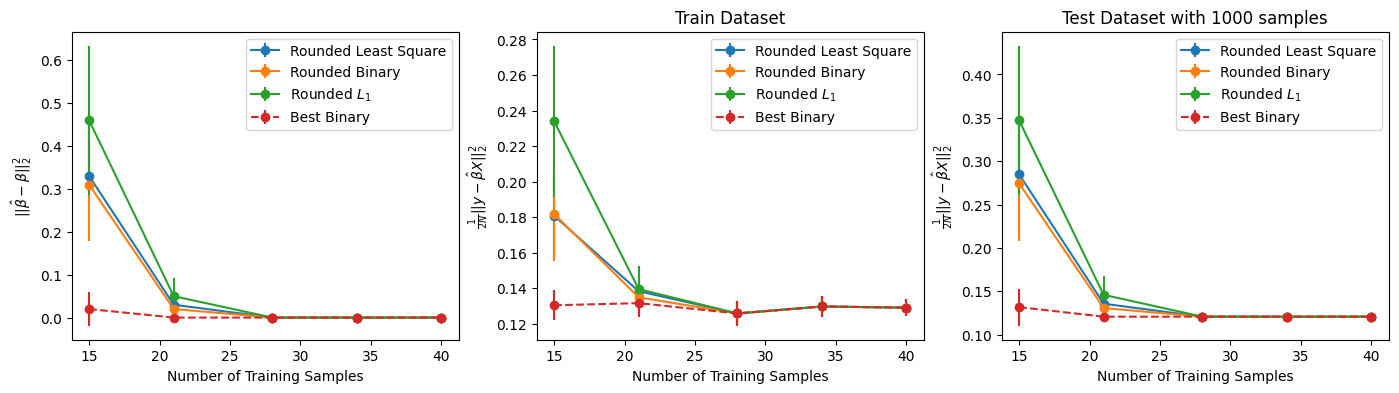

In [14]:
_, axs = plt.subplots(1, 3, figsize=(17, 4))
axs[0].errorbar(sample_size, rls_beta_hat_mean_error_per_size, yerr=np.array(rls_beta_hat_std_error_per_size)*1.96/(n_repitition**0.5), marker='o',  label='Rounded Least Square')
axs[0].errorbar(sample_size, binary_beta_hat_mean_error_per_size, yerr=np.array(binary_beta_hat_std_error_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Binary')
axs[0].errorbar(sample_size, l1_beta_hat_mean_error_per_size, yerr=np.array(l1_beta_hat_std_error_per_size)*1.96/(n_repitition**0.5), marker='o',  label='Rounded $L_1$')
axs[0].errorbar(sample_size, best_binary_beta_hat_mean_error_per_size, yerr=np.array(best_binary_beta_hat_std_error_per_size)*1.96/(n_repitition**0.5), linestyle='--',marker='o',  label='Best Binary')
# axs[0].errorbar(sample_size, ls_beta_hat_mean_error_per_size, yerr=np.array(ls_beta_hat_std_error_per_size)*1.96/(n_repitition**0.5), marker='o', label='Least Square')
axs[0].set_xlabel('Number of Training Samples')
axs[0].set_ylabel('$||\\hat{\\beta}-\\beta||_{2}^{2}$')
axs[0].legend()

axs[1].errorbar(sample_size, rls_train_mean_sse_per_size, yerr=np.array(rls_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Least Square')
axs[1].errorbar(sample_size, binary_train_mean_sse_per_size, yerr=np.array(binary_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Binary')
axs[1].errorbar(sample_size, l1_train_mean_sse_per_size, yerr=np.array(l1_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o',  label='Rounded $L_1$')
axs[1].errorbar(sample_size, best_binary_mean_train_sse_per_size, yerr=np.array(best_binary_std_train_sse_per_size)*1.96/(n_repitition**0.5), linestyle='--', marker='o', label='Best Binary')
# axs[1].errorbar(sample_size, ls_train_mean_sse_per_size, yerr=np.array(ls_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o',  label='Least Square')
axs[1].set_xlabel('Number of Training Samples')
axs[1].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[1].set_title(f'Train Dataset')
axs[1].legend()

axs[2].errorbar(sample_size, rls_test_mean_sse_per_size, yerr=np.array(rls_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Least Square')
axs[2].errorbar(sample_size, binary_test_mean_sse_per_size, yerr=np.array(binary_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Binary')
axs[2].errorbar(sample_size, l1_test_mean_sse_per_size, yerr=np.array(l1_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded $L_1$')
# axs[2].errorbar(sample_size, ls_test_mean_sse_per_size, yerr=np.array(ls_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o',  label='Least Square')
axs[2].errorbar(sample_size, best_binary_mean_test_sse_per_size, yerr=np.array(best_binary_std_test_sse_per_size)*1.96/(n_repitition**0.5), linestyle='--', marker='o', label='Best Binary')
# axs[2].hlines(best_binary_sse_test, min(sample_size), max(sample_size), linestyle='--', color='red', label='Best Binary')
axs[2].set_xlabel('Number of Training Samples')
axs[2].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[2].set_title(f'Test Dataset with 1000 samples')
axs[2].legend()

# Scenario No. 2: A dataset with non-binary weights (Rounded Least Square vs. Rounded Binary Penalty)

In this scenario, the database is generated same as before with $n_{features}=10$ but $\beta$ is a vector of non-binary values from $\beta \sim \mathcal{N}(\mu_2=0, \sigma_2^2=2)$. Now we are going to find the best binary approximation for $\beta$ that minimizes the loss function.

In [15]:
xnb, ynb, beta_nb = DataGenerator(n_samples=100, n_features=10, random_state=123)
xnb_test, ynb_test, _ = DataGenerator(n_samples=1000, weights=beta_nb, n_features=10, random_state=123)

First of all we try to find all the possible binary answers by an exhaustive algorithm.

In [16]:
alpha_range = np.logspace(-3, 0, num=10)
n_folds = 20
n_repitition = 200
nb_l1_min_alpha_per_size = []
nb_binary_min_alpha_per_size = []
nb_l1_train_mean_sse_per_size, nb_l1_train_std_sse_per_size, nb_l1_test_mean_sse_per_size, nb_l1_test_std_sse_per_size = [], [], [], []
nb_binary_train_mean_sse_per_size, nb_binary_train_std_sse_per_size, nb_binary_test_mean_sse_per_size, nb_binary_test_std_sse_per_size = [], [], [], []
nb_l1_beta_hat_mean_error_per_size,nb_l1_beta_hat_std_error_per_size, nb_binary_beta_hat_mean_error_per_size, nb_binary_beta_hat_std_error_per_size = [], [], [], []
nb_ls_train_mean_sse_per_size, nb_ls_train_std_sse_per_size, nb_ls_test_mean_sse_per_size, nb_ls_test_std_sse_per_size, nb_ls_beta_hat_mean_error_per_size, nb_ls_beta_hat_std_error_per_size = [], [], [], [], [], []
nb_rls_train_mean_sse_per_size, nb_rls_train_std_sse_per_size, nb_rls_test_mean_sse_per_size, nb_rls_test_std_sse_per_size, nb_rls_beta_hat_mean_error_per_size, nb_rls_beta_hat_std_error_per_size = [], [], [], [], [], []
nb_best_binary_mean_train_sse_per_size,nb_best_binary_std_train_sse_per_size, nb_best_binary_beta_hat_mean_error_per_size, nb_best_binary_beta_hat_std_error_per_size = [], [], [], []
nb_best_binary_mean_test_sse_per_size, nb_best_binary_std_test_sse_per_size = [], []

for ss in sample_size:

    # estimating the best alpha
    xnb_selected, ynb_selected, _ = DataGenerator(n_samples=ss, n_features=len(beta_nb), weights=beta_nb, random_state=None)
    nb_l1_min_alpha, _ = search_for_alpha_with_outer_cv(xnb_selected, ynb_selected, Lasso, alpha_range, n_folds)
    nb_l1_min_alpha_per_size.append(nb_l1_min_alpha)

    nb_binary_min_alpha, _ = search_for_alpha_with_outer_cv(xnb_selected, ynb_selected, binary_lossfunc, alpha_range, n_folds)
    nb_binary_min_alpha_per_size.append(nb_binary_min_alpha)

    # estimating the beta in iterations
    nb_l1_beta_hat_per_iter, nb_l1_rounded_beta_hat_per_iter, nb_l1_train_sse_per_iter, nb_l1_test_sse_per_iter = [], [], [], []
    nb_binary_beta_hat_per_iter, nb_binary_rounded_beta_hat_per_iter, nb_binary_train_sse_per_iter, nb_binary_test_sse_per_iter = [], [], [], []
    nb_ls_beta_hat_per_iter, nb_ls_train_sse_per_iter, nb_ls_test_sse_per_iter = [], [], []
    nb_rls_beta_hat_per_iter,nb_rls_train_sse_per_iter,nb_rls_test_sse_per_iter = [], [], []
    nb_best_binary_train_sse_per_iter, nb_best_binary_beta_hat_per_iter , nb_best_binary_test_sse_per_iter = [], [], []
    for _ in range(n_repitition):

        xnb_selected, ynb_selected, _ = DataGenerator(n_samples=ss, n_features=len(beta_nb), weights=beta_nb, random_state=None)

        nb_l1_beta_hat_per_iter.append(Lasso(nb_l1_min_alpha).fit(xnb_selected, ynb_selected).coef_)
        nb_l1_rounded_beta_hat_per_iter.append(binary_round(nb_l1_beta_hat_per_iter[-1]))
        nb_l1_train_sse_per_iter.append(squared_error(binary_round(nb_l1_beta_hat_per_iter[-1]),xnb_selected, ynb_selected))
        nb_l1_test_sse_per_iter.append(squared_error(binary_round(nb_l1_beta_hat_per_iter[-1]),xnb_test, ynb_test))

        nb_binary_beta_hat_per_iter.append(minimizer(binary_lossfunc, alpha=nb_binary_min_alpha, x=xnb_selected, y=ynb_selected))
        nb_binary_rounded_beta_hat_per_iter.append(binary_round(nb_binary_beta_hat_per_iter[-1]))
        nb_binary_train_sse_per_iter.append(squared_error(binary_round(nb_binary_beta_hat_per_iter[-1]),xnb_selected, ynb_selected))
        nb_binary_test_sse_per_iter.append(squared_error(binary_round(nb_binary_beta_hat_per_iter[-1]),xnb_test, ynb_test))

        nb_ls_beta_hat_per_iter.append(leastsquare(xnb_selected, ynb_selected))
        nb_ls_train_sse_per_iter.append(squared_error(nb_ls_beta_hat_per_iter[-1], xnb_selected, ynb_selected))
        nb_ls_test_sse_per_iter.append(squared_error(nb_ls_beta_hat_per_iter[-1], xnb_test, ynb_test))

        nb_rls_beta_hat_per_iter.append(binary_round(nb_ls_beta_hat_per_iter[-1]))
        nb_rls_train_sse_per_iter.append(squared_error(nb_rls_beta_hat_per_iter[-1], xnb_selected, ynb_selected))
        nb_rls_test_sse_per_iter.append(squared_error(nb_rls_beta_hat_per_iter[-1], xnb_test, ynb_test))

        nb_best_binary_answer, nb_best_binary_train_error = exhaustive_binary(n_answers=10, x=xnb_selected, y=ynb_selected)
        nb_best_binary_train_sse_per_iter.append(nb_best_binary_train_error)
        nb_best_binary_test_sse_per_iter.append(squared_error(nb_best_binary_answer, xnb_test, ynb_test))
        # nb_best_binary_beta_hat_per_iter.append(nb_best_binary_answer)

    nb_l1_train_mean_sse_per_size.append(np.mean(nb_l1_train_sse_per_iter))
    nb_l1_train_std_sse_per_size.append(np.std(nb_l1_train_sse_per_iter))
    nb_l1_test_mean_sse_per_size.append(np.mean(nb_l1_test_sse_per_iter))
    nb_l1_test_std_sse_per_size.append(np.std(nb_l1_test_sse_per_iter))

    nb_binary_train_mean_sse_per_size.append(np.mean(nb_binary_train_sse_per_iter))
    nb_binary_train_std_sse_per_size.append(np.std(nb_binary_train_sse_per_iter))
    nb_binary_test_mean_sse_per_size.append(np.mean(nb_binary_test_sse_per_iter))
    nb_binary_test_std_sse_per_size.append(np.std(nb_binary_test_sse_per_iter))

    nb_ls_train_mean_sse_per_size.append(np.mean(nb_ls_train_sse_per_iter))
    nb_ls_train_std_sse_per_size.append(np.std(nb_ls_train_sse_per_iter))
    nb_ls_test_mean_sse_per_size.append(np.mean(nb_ls_test_sse_per_iter))
    nb_ls_test_std_sse_per_size.append(np.std(nb_ls_test_sse_per_iter))

    nb_rls_train_mean_sse_per_size.append(np.mean(nb_rls_train_sse_per_iter))
    nb_rls_train_std_sse_per_size.append(np.std(nb_rls_train_sse_per_iter))
    nb_rls_test_mean_sse_per_size.append(np.mean(nb_rls_test_sse_per_iter))
    nb_rls_test_std_sse_per_size.append(np.std(nb_rls_test_sse_per_iter))

    nb_best_binary_mean_train_sse_per_size.append(np.mean(nb_best_binary_train_sse_per_iter))
    nb_best_binary_std_train_sse_per_size.append(np.std(nb_best_binary_train_sse_per_iter))
    nb_best_binary_mean_test_sse_per_size.append(np.mean(nb_best_binary_test_sse_per_iter))
    nb_best_binary_std_test_sse_per_size.append(np.std(nb_best_binary_test_sse_per_iter))

nb_best_binary_beta_hat_test, nb_best_binary_sse_test = exhaustive_binary(n_answers=10, x=xnb_test, y=ynb_test)
    

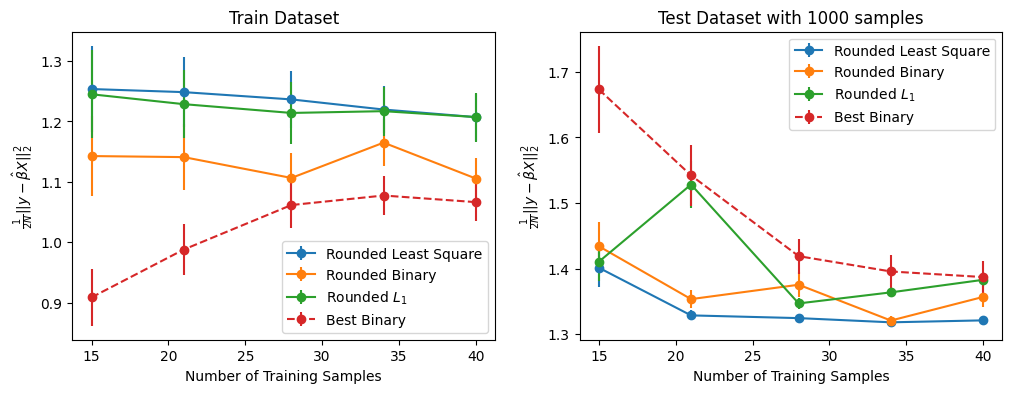

In [17]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].errorbar(sample_size, nb_rls_train_mean_sse_per_size, yerr=np.array(nb_rls_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Least Square')
axs[0].errorbar(sample_size, nb_binary_train_mean_sse_per_size, yerr=np.array(nb_binary_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Binary')
axs[0].errorbar(sample_size, nb_l1_train_mean_sse_per_size, yerr=np.array(nb_l1_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o',  label='Rounded $L_1$')
# axs[0].errorbar(sample_size, nb_ls_train_mean_sse_per_size, yerr=np.array(nb_ls_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o',  label='Least Square')
axs[0].errorbar(sample_size, nb_best_binary_mean_train_sse_per_size, yerr=np.array(nb_best_binary_std_train_sse_per_size)*1.96/(n_repitition**0.5), linestyle='--', marker='o', label='Best Binary')
axs[0].set_xlabel('Number of Training Samples')
axs[0].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[0].set_title(f'Train Dataset')
axs[0].legend()

axs[1].errorbar(sample_size, nb_rls_test_mean_sse_per_size, yerr=np.array(nb_rls_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Least Square')
axs[1].errorbar(sample_size, nb_binary_test_mean_sse_per_size, yerr=np.array(nb_binary_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Binary')
axs[1].errorbar(sample_size, nb_l1_test_mean_sse_per_size, yerr=np.array(nb_l1_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded $L_1$')
# axs[1].errorbar(sample_size, nb_ls_test_mean_sse_per_size, yerr=np.array(nb_ls_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o',  label='Least Square')
axs[1].errorbar(sample_size, nb_best_binary_mean_test_sse_per_size, yerr=np.array(nb_best_binary_std_test_sse_per_size)*1.96/(n_repitition**0.5), linestyle='--', marker='o', label='Best Binary')
# axs[1].hlines(nb_best_binary_sse_test, min(sample_size), max(sample_size), linestyle='--',color='darkred', label='Best Binary')
axs[1].set_xlabel('Number of Training Samples')
axs[1].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[1].set_title(f'Test Dataset with 1000 samples')
axs[1].legend()

# Scenario No. 3 A Special Case Study I

In this scenario the weights vector is considered as $\beta = [0.5, 0.5, 0]$. Also the features are not independent from each other and thery are defined as follows

\begin{align*}
y&= 0.5x_1 + 0.5x_2 + \epsilon_1 \\
x_3&=0.5x_1 + 0.5x_2 + \epsilon_2 \\
X&=[x_1, x_2] \sim N_p(\boldsymbol{\mu}, \Sigma)\\
\epsilon_1 &\sim \mathcal{N}(0, \sigma_1^2) \\
\epsilon_2 &\sim \mathcal{N}(0, \sigma_2^2) 
\end{align*}

We assume the covariance matrix for $x_1$ and $x_2$ as below
\begin{align*}
\Sigma &= 
\begin{pmatrix}
2 & 0\\
0 & 2\\
\end{pmatrix}
\end{align*}

Here we try to calculate the expected value of squared estimation error with respect to two binary approximation as $\tilde{\beta}=[1,1,0]$ and $\tilde{\beta}=[0,0,1]$ ($\tilde{\beta}$ is a notation for the binary approximation).

\begin{align*}
1: \tilde{\beta} =& [1,1,0] \to \hat{y}= x_1 + x_2 \\
E[(y-\hat{y})^2] =&E[(0.5x_1+0.5x_2+\epsilon_1-x_1-x_2)^2]\\
 =&E[(-0.5x_1-0.5x_2+\epsilon_1)^2]\\
 =&E[(0.25(x_1+x_2)^2-\epsilon_1(x_1+x_2)+\epsilon_1^2)]\\
 =&0.25E[x_1^2+x_2^2+2x_1x_2]-E[\epsilon_1(x_1+x_2)]+E[\epsilon_1^2]\\
 =&0.25E[x_1^2]+0.25E[x_2^2]+0.5E[x_1]E[x_2]-E[\epsilon_1]E[x_1]-E[\epsilon_1]E[x_2]+E[\epsilon_1^2]\\
 =&0.25E[x_1^2]+0.25E[x_2^2]+E[\epsilon_1^2]\\
\\
2: \tilde{\beta} =& [0,0,1] \to \hat{y}= x_3 \\
E[(y-\hat{y})^2] =&E[(0.5x_1+0.5x_2+\epsilon_1-x_3)^2]\\
 =&E[(\epsilon_1-\epsilon_2)^2]=E[\epsilon_1^2]+E[\epsilon_2^2]
\end{align*}


In [13]:
def DataGenerator_x123(n_samples,feature_mean, feature_cov, sigma1, sigma2, randome_state=None):
    RNG = np.random.default_rng(seed=randome_state)
    beta = np.array([0.5, 0.5])
    x12 = RNG.multivariate_normal(feature_mean, feature_cov, size=n_samples)
    x3 = (x12.dot(beta) + RNG.normal(0, sigma2, size=n_samples)).reshape(-1,1)
    x = np.hstack((x12, x3))
    y = x12.dot(beta) + RNG.normal(0, sigma1, size=n_samples)
    return x, y

In [14]:
x_test, y_test = DataGenerator_x123(n_samples=10000, feature_mean=np.zeros(2), feature_cov=2*np.eye(2), sigma1=0.5, sigma2=0.5, randome_state=123)

In [ ]:
alpha_range = np.logspace(-3, 0, num=10)
n_folds = 20
n_repitition = 100
sample_size = np.round(500*np.array(np.linspace(0.15,1,50))).astype(int)
x123_l1_train_mean_sse_per_size,x123_l1_train_std_sse_per_size, x123_l1_test_mean_sse_per_size, x123_l1_test_std_sse_per_size = [], [], [], []
x123_l1_min_alpha_per_size,x123_l1_min_sse_valid_per_size,x123_l1_mean_sse_valid_per_size = [], [], []
x123_binary_min_alpha_per_size, x123_binary_min_sse_valid_per_size, x123_binary_mean_sse_valid_per_size = [], [], []
x123_binary_train_mean_sse_per_size, x123_binary_train_std_sse_per_size, x123_binary_test_mean_sse_per_size, x123_binary_test_std_sse_per_size = [], [], [], []
x123_ls_train_mean_sse_per_size, x123_ls_train_std_sse_per_size, x123_ls_test_mean_sse_per_size, x123_ls_test_std_sse_per_size, x123_ls_beta_hat_mean_error_per_size, x123_ls_beta_hat_std_error_per_size = [], [], [], [], [], []
x123_rls_train_mean_sse_per_size, x123_rls_train_std_sse_per_size, x123_rls_test_mean_sse_per_size, x123_rls_test_std_sse_per_size, x123_rls_beta_hat_mean_error_per_size, x123_rls_beta_hat_std_error_per_size = [], [], [], [], [], []
x123_best_binary_mean_train_sse_per_size,x123_best_binary_std_train_sse_per_size, x123_best_binary_beta_hat_mean_error_per_size, x123_best_binary_beta_hat_std_error_per_size = [], [], [], []
x123_best_binary_mean_test_sse_per_size, x123_best_binary_std_test_sse_per_size = [], []

for ss in sample_size:
    print(ss)
    # estimating the best alpha
    x_selected, y_selected = DataGenerator_x123(n_samples=ss, feature_mean=np.zeros(2), feature_cov=2*np.eye(2), sigma1=0.5, sigma2=0.5, randome_state=None)
    x123_l1_min_alpha, _ = search_for_alpha_with_outer_cv(x_selected, y_selected, Lasso, alpha_range, n_folds)
    x123_l1_min_alpha_per_size.append(x123_l1_min_alpha)

    x123_binary_min_alpha, _ = search_for_alpha_with_outer_cv(x_selected, y_selected, binary_lossfunc, alpha_range, n_folds)
    x123_binary_min_alpha_per_size.append(x123_binary_min_alpha)

    # estimating the beta in iterations
    x123_l1_beta_hat_per_iter, x123_l1_rounded_beta_hat_per_iter, x123_l1_train_sse_per_iter, x123_l1_test_sse_per_iter = [], [], [], []
    x123_binary_beta_hat_per_iter, x123_binary_rounded_beta_hat_per_iter, x123_binary_train_sse_per_iter, x123_binary_test_sse_per_iter = [], [], [], []
    x123_ls_beta_hat_per_iter, x123_ls_train_sse_per_iter, x123_ls_test_sse_per_iter = [], [], []
    x123_rls_beta_hat_per_iter,x123_rls_train_sse_per_iter,x123_rls_test_sse_per_iter = [], [], []
    x123_best_binary_train_sse_per_iter, x123_best_binary_beta_hat_per_iter, x123_best_binary_test_sse_per_iter = [], [], []

    for _ in range(n_repitition):

        x_selected, y_selected = DataGenerator_x123(n_samples=ss, feature_mean=np.zeros(2), feature_cov=2*np.eye(2), sigma1=0.5, sigma2=0.5, randome_state=None)

        x123_l1_beta_hat_per_iter.append(Lasso(x123_l1_min_alpha).fit(x_selected, y_selected).coef_)
        x123_l1_rounded_beta_hat_per_iter.append(binary_round(x123_l1_beta_hat_per_iter[-1]))
        x123_l1_train_sse_per_iter.append(squared_error(binary_round(x123_l1_beta_hat_per_iter[-1]),x_selected, y_selected))
        x123_l1_test_sse_per_iter.append(squared_error(binary_round(x123_l1_beta_hat_per_iter[-1]),x_test, y_test))

        x123_binary_beta_hat_per_iter.append(minimizer(binary_lossfunc, alpha=x123_binary_min_alpha, x=x_selected, y=y_selected))
        x123_binary_rounded_beta_hat_per_iter.append(binary_round(x123_binary_beta_hat_per_iter[-1]))
        x123_binary_train_sse_per_iter.append(squared_error(binary_round(x123_binary_beta_hat_per_iter[-1]),x_selected, y_selected))
        x123_binary_test_sse_per_iter.append(squared_error(binary_round(x123_binary_beta_hat_per_iter[-1]),x_test, y_test))

        x123_ls_beta_hat_per_iter.append(leastsquare(x_selected, y_selected))
        x123_ls_train_sse_per_iter.append(squared_error(x123_ls_beta_hat_per_iter[-1], x_selected, y_selected))
        x123_ls_test_sse_per_iter.append(squared_error(x123_ls_beta_hat_per_iter[-1], x_test, y_test))

        x123_rls_beta_hat_per_iter.append(binary_round(x123_ls_beta_hat_per_iter[-1]))
        x123_rls_train_sse_per_iter.append(squared_error(x123_rls_beta_hat_per_iter[-1], x_selected, y_selected))
        x123_rls_test_sse_per_iter.append(squared_error(x123_rls_beta_hat_per_iter[-1], x_test, y_test))

        x123_best_binary_answer, x123_best_binary_train_error = exhaustive_binary(n_answers=3, x=x_selected, y=y_selected)
        x123_best_binary_train_sse_per_iter.append(x123_best_binary_train_error)
        x123_best_binary_beta_hat_per_iter.append(x123_best_binary_answer)
        x123_best_binary_test_sse_per_iter.append(squared_error(x123_best_binary_answer, x_test, y_test))

    x123_l1_train_mean_sse_per_size.append(np.mean(x123_l1_train_sse_per_iter))
    x123_l1_train_std_sse_per_size.append(np.std(x123_l1_train_sse_per_iter))
    x123_l1_test_mean_sse_per_size.append(np.mean(x123_l1_test_sse_per_iter))
    x123_l1_test_std_sse_per_size.append(np.std(x123_l1_test_sse_per_iter))
    # x123_l1_beta_hat_mean_error_per_size.append(np.mean(np.sum((best_binary_nb-nb_l1_rounded_beta_hat_per_iter)**2, axis=1)))
    # x123_l1_beta_hat_std_error_per_size.append(np.std(np.sum((best_binary_nb-nb_l1_rounded_beta_hat_per_iter)**2, axis=1)))

    x123_binary_train_mean_sse_per_size.append(np.mean(x123_binary_train_sse_per_iter))
    x123_binary_train_std_sse_per_size.append(np.std(x123_binary_train_sse_per_iter))
    x123_binary_test_mean_sse_per_size.append(np.mean(x123_binary_test_sse_per_iter))
    x123_binary_test_std_sse_per_size.append(np.std(x123_binary_test_sse_per_iter))
    # x123_binary_beta_hat_mean_error_per_size.append(np.mean(np.sum((best_possible[0]-x123_binary_rounded_beta_hat_per_iter)**2, axis=1)))
    # x123_binary_beta_hat_std_error_per_size.append(np.std(np.sum((best_possible[0]-x123_binary_rounded_beta_hat_per_iter)**2, axis=1)))

    x123_ls_train_mean_sse_per_size.append(np.mean(x123_ls_train_sse_per_iter))
    x123_ls_train_std_sse_per_size.append(np.std(x123_ls_train_sse_per_iter))
    x123_ls_test_mean_sse_per_size.append(np.mean(x123_ls_test_sse_per_iter))
    x123_ls_test_std_sse_per_size.append(np.std(x123_ls_test_sse_per_iter))
    # x123_ls_beta_hat_mean_error_per_size.append(np.mean(np.sum((best_possible[0]-x123_ls_beta_hat_per_iter)**2, axis=1)))
    # x123_ls_beta_hat_std_error_per_size.append(np.std(np.sum((best_possible[0]-x123_ls_beta_hat_per_iter)**2, axis=1)))

    x123_rls_train_mean_sse_per_size.append(np.mean(x123_rls_train_sse_per_iter))
    x123_rls_train_std_sse_per_size.append(np.std(x123_rls_train_sse_per_iter))
    x123_rls_test_mean_sse_per_size.append(np.mean(x123_rls_test_sse_per_iter))
    x123_rls_test_std_sse_per_size.append(np.std(x123_rls_test_sse_per_iter))
    # x123_rls_beta_hat_mean_error_per_size.append(np.mean(np.sum((best_possible[0]-x123_rls_beta_hat_per_iter)**2, axis=1)))
    # x123_rls_beta_hat_std_error_per_size.append(np.std(np.sum((best_possible[0]-x123_rls_beta_hat_per_iter)**2, axis=1)))

    x123_best_binary_mean_train_sse_per_size.append(np.mean(x123_best_binary_train_sse_per_iter))
    x123_best_binary_std_train_sse_per_size.append(np.std(x123_best_binary_train_sse_per_iter))
    x123_best_binary_mean_test_sse_per_size.append(np.mean(x123_best_binary_test_sse_per_iter))
    x123_best_binary_std_test_sse_per_size.append(np.std(x123_best_binary_test_sse_per_iter))

x123_best_binary_beta_hat_test, x123_best_binary_sse_test = exhaustive_binary(n_answers=3, x=x_test, y=y_test)
    

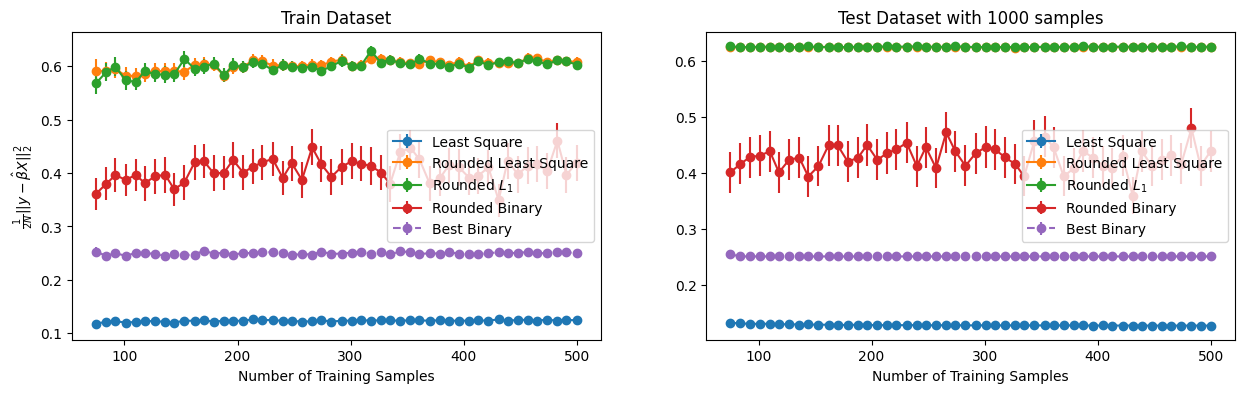

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].errorbar(sample_size, x123_ls_train_mean_sse_per_size, yerr=np.array(x123_ls_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o',  label='Least Square')
axs[0].errorbar(sample_size, x123_rls_train_mean_sse_per_size, yerr=np.array(x123_rls_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Least Square')
axs[0].errorbar(sample_size, x123_l1_train_mean_sse_per_size, yerr=np.array(x123_l1_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded $L_1$')
axs[0].errorbar(sample_size, x123_binary_train_mean_sse_per_size, yerr=np.array(x123_binary_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Binary')
axs[0].errorbar(sample_size, x123_best_binary_mean_train_sse_per_size, yerr=np.array(x123_best_binary_std_train_sse_per_size)*1.96/(n_repitition**0.5),linestyle='--', marker='o', label='Best Binary')
axs[0].set_xlabel('Number of Training Samples')
axs[0].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[0].set_title('Train Dataset')
axs[0].legend()

axs[1].errorbar(sample_size, x123_ls_test_mean_sse_per_size, yerr=np.array(x123_ls_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o',  label='Least Square')
axs[1].errorbar(sample_size, x123_rls_test_mean_sse_per_size, yerr=np.array(x123_rls_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Least Square')
axs[1].errorbar(sample_size, x123_l1_test_mean_sse_per_size, yerr=np.array(x123_l1_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded $L_1$')
axs[1].errorbar(sample_size, x123_binary_test_mean_sse_per_size, yerr=np.array(x123_binary_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Binary')
axs[1].errorbar(sample_size, x123_best_binary_mean_test_sse_per_size, yerr=np.array(x123_best_binary_std_test_sse_per_size)*1.96/(n_repitition**0.5),linestyle='--', marker='o', label='Best Binary')
# axs[1].hlines(x123_best_binary_sse_test, min(sample_size), max(sample_size), linestyle='--',color='purple', label='Best Binary')
axs[1].set_xlabel('Number of Training Samples')
# axs[1].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[1].set_title('Test Dataset with 1000 samples')
axs[1].legend()


Now we count the number of each binary combinations as a best binary solution with respect to each method. Here, we consider 100 training points (the last sample size) with 100 repititions, then we can see what is the solution of each repitition.

In [22]:
import itertools

all_answer_lst = list(itertools.product([0, 1], repeat=3))

for pa in all_answer_lst:
    print(f'Rounded Binary: {pa} --> {len([res for res in x123_binary_rounded_beta_hat_per_iter if tuple(res)==pa])}')
print()
for pa in all_answer_lst:
    print(f'Rounded Least Square: {pa} --> {len([res for res in x123_rls_beta_hat_per_iter if tuple(res)==pa])}')
print()
for pa in all_answer_lst:
    print(f'Best Binary: {pa} --> {len([res for res in x123_best_binary_beta_hat_per_iter if tuple(res)==pa])}')

Rounded Binary: (0, 0, 0) --> 19
Rounded Binary: (0, 0, 1) --> 50
Rounded Binary: (0, 1, 0) --> 13
Rounded Binary: (0, 1, 1) --> 0
Rounded Binary: (1, 0, 0) --> 13
Rounded Binary: (1, 0, 1) --> 0
Rounded Binary: (1, 1, 0) --> 5
Rounded Binary: (1, 1, 1) --> 0

Rounded Least Square: (0, 0, 0) --> 38
Rounded Least Square: (0, 0, 1) --> 0
Rounded Least Square: (0, 1, 0) --> 12
Rounded Least Square: (0, 1, 1) --> 0
Rounded Least Square: (1, 0, 0) --> 18
Rounded Least Square: (1, 0, 1) --> 0
Rounded Least Square: (1, 1, 0) --> 32
Rounded Least Square: (1, 1, 1) --> 0

Best Binary: (0, 0, 0) --> 0
Best Binary: (0, 0, 1) --> 100
Best Binary: (0, 1, 0) --> 0
Best Binary: (0, 1, 1) --> 0
Best Binary: (1, 0, 0) --> 0
Best Binary: (1, 0, 1) --> 0
Best Binary: (1, 1, 0) --> 0
Best Binary: (1, 1, 1) --> 0


Exhaustive method gives the best binary approximation which is $\tilde{\beta}=[0,0,1]$. According to the results, it seems that rounded least square and rounded $L_1$ failed to find the best binary approximation $\tilde{\beta}=[0,0,1]$. In other hand, the rounded binary penalty is more successful to obtain the best approximation, however, there are some wrong answers that their repitition is not negligible. We guess that following reasons could be effective:

- Noise
- Randomness at each repitition
- Failure of optimisation algorithm to find the optimum because of the non-convex objective function

In the next step, we try a different form of binary penalty as follows

\begin{equation*}
P_{Binary}(\beta) = \sum_{i=0}^{p} \Biggl\{ 
    \begin{array}{rcl}
     -\beta_i^2 & if & \beta_i < 0\\
     2\beta_i^2 & if & 0 \le \beta_i < 0.25\\
     -2(\beta_i-0.5)^2+0.25 & if & 0.25 \le \beta_i \le 0.75\\
     2(\beta_i-1)^2 & if & 0.75 < \beta_i \le 1\\
    (\beta_i-1)^2 & if & \beta_i > 1
    \end{array}
\end{equation*}


0.25

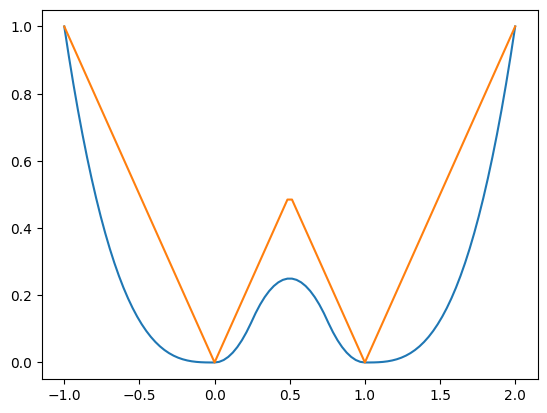

In [11]:
beta_range = np.linspace(-1,2,100)
def binary_type1(b):
    if b<=0.5:
        out = abs(b)
    else:
        out = abs(b-1)
    return out

def binary_type2(b):
    if b<0:
        out = -b**3
    if b>1:
        out = (b-1)**3
    if b>=0 and b<=0.25:
        out = 2*b**2
    if b >0.25 and b <(3/4):
        out = -2*(b-0.5)**2+0.25
        # out = -0.5*abs(b-0.5)+0.25
    if b>=(3/4) and b<=1:
        out = 2*(b-1)**2
    # if b>=0 and b<=0.5:
    #     out = 0.25/(1+np.exp(-20*(b-0.25)))
    # if b>0.5 and b<=1:
    #     out = 0.25/(1+np.exp(20*(b-(3/4))))
    # if b>=0 and b<=1:
        # out = -4*(b-0.5)**2+1
    return out
beta_penalty_type2 = [binary_type2(beta_input) for beta_input in beta_range]
beta_penalty_type1 = [binary_type1(beta_input) for beta_input in beta_range]
plt.plot(beta_range, beta_penalty_type2)
plt.plot(beta_range, beta_penalty_type1)
binary_type2(0.5)

In [19]:
alpha_range = np.logspace(-3, 0, num=10)
n_folds = 20
n_repitition = 200
sample_size = np.round(200*np.array(np.linspace(0.15,1,10))).astype(int)
x123_binary_min_alpha_per_size, x123_binary_min_sse_valid_per_size, x123_binary_mean_sse_valid_per_size = [], [], []
x123_binary_train_mean_sse_per_size, x123_binary_train_std_sse_per_size, x123_binary_test_mean_sse_per_size, x123_binary_test_std_sse_per_size = [], [], [], []

x123_type2_binary_min_alpha_per_size, x123_type2_binary_min_sse_valid_per_size, x123_type2_binary_mean_sse_valid_per_size = [], [], []
x123_type2_binary_train_mean_sse_per_size, x123_type2_binary_train_std_sse_per_size, x123_type2_binary_test_mean_sse_per_size, x123_type2_binary_test_std_sse_per_size = [], [], [], []

for ss in sample_size:
    print(ss)
    # estimating the best alpha
    x_selected, y_selected = DataGenerator_x123(n_samples=ss, feature_mean=np.zeros(2), feature_cov=2*np.eye(2), sigma1=0.5, sigma2=0.5, randome_state=123)

    x123_binary_min_alpha, _ = search_for_alpha_with_outer_cv(x_selected, y_selected, binary_lossfunc, alpha_range, n_folds)
    x123_binary_min_alpha_per_size.append(x123_binary_min_alpha)

    x123_type2_binary_min_alpha, _ = search_for_alpha_with_outer_cv(x_selected, y_selected, binary_lossfunc_type2, alpha_range, n_folds)
    x123_type2_binary_min_alpha_per_size.append(x123_type2_binary_min_alpha)

    # estimating the beta in iterations
    x123_binary_beta_hat_per_iter, x123_binary_rounded_beta_hat_per_iter, x123_binary_train_sse_per_iter, x123_binary_test_sse_per_iter = [], [], [], []
    x123_type2_binary_beta_hat_per_iter, x123_type2_binary_rounded_beta_hat_per_iter, x123_type2_binary_train_sse_per_iter, x123_type2_binary_test_sse_per_iter = [], [], [], []
    for _ in range(n_repitition):

        x_selected, y_selected = DataGenerator_x123(n_samples=ss, feature_mean=np.zeros(2), feature_cov=2*np.eye(2), sigma1=0.5, sigma2=0.5, randome_state=None)

        x123_binary_beta_hat_per_iter.append(minimizer(binary_lossfunc, alpha=x123_binary_min_alpha, x=x_selected, y=y_selected))
        x123_binary_rounded_beta_hat_per_iter.append(binary_round(x123_binary_beta_hat_per_iter[-1]))
        x123_binary_train_sse_per_iter.append(squared_error(binary_round(x123_binary_beta_hat_per_iter[-1]),x_selected, y_selected))
        x123_binary_test_sse_per_iter.append(squared_error(binary_round(x123_binary_beta_hat_per_iter[-1]),x_test, y_test))

        x123_type2_binary_beta_hat_per_iter.append(minimizer(binary_lossfunc_type2, alpha=x123_type2_binary_min_alpha, x=x_selected, y=y_selected))
        x123_type2_binary_rounded_beta_hat_per_iter.append(binary_round(x123_type2_binary_beta_hat_per_iter[-1]))
        x123_type2_binary_train_sse_per_iter.append(squared_error(binary_round(x123_type2_binary_beta_hat_per_iter[-1]),x_selected, y_selected))
        x123_type2_binary_test_sse_per_iter.append(squared_error(binary_round(x123_type2_binary_beta_hat_per_iter[-1]),x_test, y_test))

    x123_binary_train_mean_sse_per_size.append(np.mean(x123_binary_train_sse_per_iter))
    x123_binary_train_std_sse_per_size.append(np.std(x123_binary_train_sse_per_iter))
    x123_binary_test_mean_sse_per_size.append(np.mean(x123_binary_test_sse_per_iter))
    x123_binary_test_std_sse_per_size.append(np.std(x123_binary_test_sse_per_iter))

    x123_type2_binary_train_mean_sse_per_size.append(np.mean(x123_type2_binary_train_sse_per_iter))
    x123_type2_binary_train_std_sse_per_size.append(np.std(x123_type2_binary_train_sse_per_iter))
    x123_type2_binary_test_mean_sse_per_size.append(np.mean(x123_type2_binary_test_sse_per_iter))
    x123_type2_binary_test_std_sse_per_size.append(np.std(x123_type2_binary_test_sse_per_iter))
    

30
49
68
87
106
124
143
162
181
200


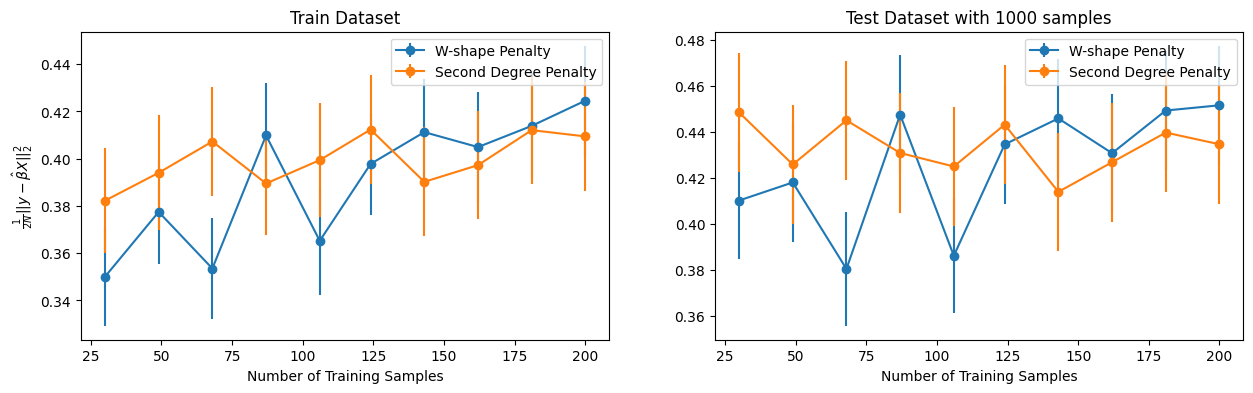

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].errorbar(sample_size, x123_binary_train_mean_sse_per_size, yerr=np.array(x123_binary_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='W-shape Penalty')
axs[0].errorbar(sample_size, x123_type2_binary_train_mean_sse_per_size, yerr=np.array(x123_type2_binary_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Second Degree Penalty')
axs[0].set_xlabel('Number of Training Samples')
axs[0].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[0].set_title('Train Dataset')
axs[0].legend()

axs[1].errorbar(sample_size, x123_binary_test_mean_sse_per_size, yerr=np.array(x123_binary_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='W-shape Penalty')
axs[1].errorbar(sample_size, x123_type2_binary_test_mean_sse_per_size, yerr=np.array(x123_type2_binary_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Second Degree Penalty')
axs[1].set_xlabel('Number of Training Samples')
# axs[1].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[1].set_title('Test Dataset with 1000 samples')
axs[1].legend()

In [22]:
all_answer_lst = list(itertools.product([0, 1], repeat=3))
for pa in all_answer_lst:
    print(f'W-shape Penalty: {pa} --> {len([res for res in x123_binary_rounded_beta_hat_per_iter if tuple(res)==pa])}')
print()
for pa in all_answer_lst:
    print(f'Second Degree Penalty: {pa} --> {len([res for res in x123_type2_binary_rounded_beta_hat_per_iter if tuple(res)==pa])}')

W-shape Penalty: (0, 0, 0) --> 26
W-shape Penalty: (0, 0, 1) --> 93
W-shape Penalty: (0, 1, 0) --> 22
W-shape Penalty: (0, 1, 1) --> 0
W-shape Penalty: (1, 0, 0) --> 35
W-shape Penalty: (1, 0, 1) --> 0
W-shape Penalty: (1, 1, 0) --> 24
W-shape Penalty: (1, 1, 1) --> 0

Second Degree Penalty: (0, 0, 0) --> 22
Second Degree Penalty: (0, 0, 1) --> 102
Second Degree Penalty: (0, 1, 0) --> 23
Second Degree Penalty: (0, 1, 1) --> 0
Second Degree Penalty: (1, 0, 0) --> 29
Second Degree Penalty: (1, 0, 1) --> 0
Second Degree Penalty: (1, 1, 0) --> 24
Second Degree Penalty: (1, 1, 1) --> 0


# Scenario No. 4 A Special Case Study II

This scenario would be defined as follows

\begin{align*}
y&= 0.5x_1 + 0.5x_2 + x_3 + 0.48x_4 + 0.2x_5 + \epsilon_1 \\
x_6&=0.5x_1 + 0.5x_2 + \epsilon_2 \\
x_7&=x_3 + 0.48x_4 + \epsilon_3 \\
\epsilon_1 &\sim \mathcal{N}(0, \sigma_1^2), \quad 
\epsilon_2 \sim \mathcal{N}(0, \sigma_2^2), \quad
\epsilon_3 \sim \mathcal{N}(0, \sigma_3^2)
\end{align*}


We assume the noise variances and covariance matrix for $x_1$ and $x_2$ as below

\begin{align*}
\sigma_1 &= 0.5 , \quad \sigma_2 = 0.5, \quad \sigma_3= 0.5 \\
\Sigma &= 2\mathcal{I}_5
\end{align*}

In [23]:
def DataGenerator_x1_7(n_samples,feature_mean=np.zeros(5), feature_cov=2*np.eye(5), sigma1=0.5, sigma2=0.5, sigma3=0.5, randome_state=None):
    RNG = np.random.default_rng(seed=randome_state)
    beta = np.array([0.5, 0.5, 1, 0.48, 0.2])
    beta6 = np.array([0.5, 0.5])
    beta7 = np.array([1, 0.48])
    x1_5 = RNG.multivariate_normal(feature_mean, feature_cov, size=n_samples)
    x6 = (x1_5[:,:2].dot(beta6) + RNG.normal(0, sigma2, size=n_samples)).reshape(-1,1)
    x7 = (x1_5[:,2:4].dot(beta7) + RNG.normal(0, sigma3, size=n_samples)).reshape(-1,1)
    x = np.hstack((x1_5, x6, x7))
    y = x1_5.dot(beta) + RNG.normal(0, sigma1, size=n_samples)
    return x, y

In [24]:
x7_test, y7_test = DataGenerator_x1_7(n_samples=10000, randome_state=123)

In [ ]:
alpha_range = np.logspace(-3, 0, num=10)
n_folds = 20
n_repitition = 100
sample_size = np.round(200*np.array(np.linspace(0.2,1,20))).astype(int)
x7_l1_train_mean_sse_per_size,x7_l1_train_std_sse_per_size, x7_l1_test_mean_sse_per_size, x7_l1_test_std_sse_per_size = [], [], [], []
x7_l1_min_alpha_per_size,x7_l1_min_sse_valid_per_size,x7_l1_mean_sse_valid_per_size = [], [], []
x7_binary_min_alpha_per_size, x7_binary_min_sse_valid_per_size, x7_binary_mean_sse_valid_per_size = [], [], []
x7_binary_train_mean_sse_per_size, x7_binary_train_std_sse_per_size, x7_binary_test_mean_sse_per_size, x7_binary_test_std_sse_per_size = [], [], [], []
x7_ls_train_mean_sse_per_size, x7_ls_train_std_sse_per_size, x7_ls_test_mean_sse_per_size, x7_ls_test_std_sse_per_size, x7_ls_beta_hat_mean_error_per_size, x7_ls_beta_hat_std_error_per_size = [], [], [], [], [], []
x7_rls_train_mean_sse_per_size, x7_rls_train_std_sse_per_size, x7_rls_test_mean_sse_per_size, x7_rls_test_std_sse_per_size, x7_rls_beta_hat_mean_error_per_size, x7_rls_beta_hat_std_error_per_size = [], [], [], [], [], []
x7_best_binary_mean_train_sse_per_size,x7_best_binary_std_train_sse_per_size, x7_best_binary_beta_hat_mean_error_per_size, x7_best_binary_beta_hat_std_error_per_size = [], [], [], []
x7_best_binary_mean_test_sse_per_size, x7_best_binary_std_test_sse_per_size = [], []

for ss in sample_size:
    print(ss)
    # estimating the best alpha
    x_selected, y_selected = DataGenerator_x1_7(n_samples=ss, randome_state=123)
    x7_l1_min_alpha, _ = search_for_alpha_with_outer_cv(x_selected, y_selected, Lasso, alpha_range, n_folds)
    x7_l1_min_alpha_per_size.append(x7_l1_min_alpha)

    x7_binary_min_alpha, _ = search_for_alpha_with_outer_cv(x_selected, y_selected, binary_lossfunc_type2, alpha_range, n_folds)
    x7_binary_min_alpha_per_size.append(x7_binary_min_alpha)

    # estimating the beta in iterations
    x7_l1_beta_hat_per_iter, x7_l1_rounded_beta_hat_per_iter, x7_l1_train_sse_per_iter, x7_l1_test_sse_per_iter = [], [], [], []
    x7_binary_beta_hat_per_iter, x7_binary_rounded_beta_hat_per_iter, x7_binary_train_sse_per_iter, x7_binary_test_sse_per_iter = [], [], [], []
    x7_ls_beta_hat_per_iter, x7_ls_train_sse_per_iter, x7_ls_test_sse_per_iter = [], [], []
    x7_rls_beta_hat_per_iter,x7_rls_train_sse_per_iter,x7_rls_test_sse_per_iter = [], [], []
    x7_best_binary_train_sse_per_iter, x7_best_binary_beta_hat_per_iter, x7_best_binary_test_sse_per_iter = [], [], []
    for _ in range(n_repitition):

        x_selected, y_selected = DataGenerator_x1_7(n_samples=ss, randome_state=None)

        x7_l1_beta_hat_per_iter.append(Lasso(x7_l1_min_alpha).fit(x_selected, y_selected).coef_)
        x7_l1_rounded_beta_hat_per_iter.append(binary_round(x7_l1_beta_hat_per_iter[-1]))
        x7_l1_train_sse_per_iter.append(squared_error(binary_round(x7_l1_beta_hat_per_iter[-1]),x_selected, y_selected))
        x7_l1_test_sse_per_iter.append(squared_error(binary_round(x7_l1_beta_hat_per_iter[-1]),x7_test, y7_test))

        x7_binary_beta_hat_per_iter.append(minimizer(binary_lossfunc_type2, alpha=x7_binary_min_alpha, x=x_selected, y=y_selected))
        x7_binary_rounded_beta_hat_per_iter.append(binary_round(x7_binary_beta_hat_per_iter[-1]))
        x7_binary_train_sse_per_iter.append(squared_error(binary_round(x7_binary_beta_hat_per_iter[-1]),x_selected, y_selected))
        x7_binary_test_sse_per_iter.append(squared_error(binary_round(x7_binary_beta_hat_per_iter[-1]),x7_test, y7_test))

        x7_ls_beta_hat_per_iter.append(leastsquare(x_selected, y_selected))
        x7_ls_train_sse_per_iter.append(squared_error(x7_ls_beta_hat_per_iter[-1], x_selected, y_selected))
        x7_ls_test_sse_per_iter.append(squared_error(x7_ls_beta_hat_per_iter[-1], x7_test, y7_test))

        x7_rls_beta_hat_per_iter.append(binary_round(x7_ls_beta_hat_per_iter[-1]))
        x7_rls_train_sse_per_iter.append(squared_error(x7_rls_beta_hat_per_iter[-1], x_selected, y_selected))
        x7_rls_test_sse_per_iter.append(squared_error(x7_rls_beta_hat_per_iter[-1], x7_test, y7_test))

        x7_best_binary_answer, x7_best_binary_train_error = exhaustive_binary(n_answers=7, x=x_selected, y=y_selected)
        x7_best_binary_train_sse_per_iter.append(x7_best_binary_train_error)
        x7_best_binary_beta_hat_per_iter.append(x7_best_binary_answer)
        x7_best_binary_test_sse_per_iter.append(squared_error(x7_best_binary_answer, x7_test, y7_test))

    x7_l1_train_mean_sse_per_size.append(np.mean(x7_l1_train_sse_per_iter))
    x7_l1_train_std_sse_per_size.append(np.std(x7_l1_train_sse_per_iter))
    x7_l1_test_mean_sse_per_size.append(np.mean(x7_l1_test_sse_per_iter))
    x7_l1_test_std_sse_per_size.append(np.std(x7_l1_test_sse_per_iter))

    x7_binary_train_mean_sse_per_size.append(np.mean(x7_binary_train_sse_per_iter))
    x7_binary_train_std_sse_per_size.append(np.std(x7_binary_train_sse_per_iter))
    x7_binary_test_mean_sse_per_size.append(np.mean(x7_binary_test_sse_per_iter))
    x7_binary_test_std_sse_per_size.append(np.std(x7_binary_test_sse_per_iter))

    x7_ls_train_mean_sse_per_size.append(np.mean(x7_ls_train_sse_per_iter))
    x7_ls_train_std_sse_per_size.append(np.std(x7_ls_train_sse_per_iter))
    x7_ls_test_mean_sse_per_size.append(np.mean(x7_ls_test_sse_per_iter))
    x7_ls_test_std_sse_per_size.append(np.std(x7_ls_test_sse_per_iter))

    x7_rls_train_mean_sse_per_size.append(np.mean(x7_rls_train_sse_per_iter))
    x7_rls_train_std_sse_per_size.append(np.std(x7_rls_train_sse_per_iter))
    x7_rls_test_mean_sse_per_size.append(np.mean(x7_rls_test_sse_per_iter))
    x7_rls_test_std_sse_per_size.append(np.std(x7_rls_test_sse_per_iter))

    x7_best_binary_mean_train_sse_per_size.append(np.mean(x7_best_binary_train_sse_per_iter))
    x7_best_binary_std_train_sse_per_size.append(np.std(x7_best_binary_train_sse_per_iter))
    x7_best_binary_mean_test_sse_per_size.append(np.mean(x7_best_binary_test_sse_per_iter))
    x7_best_binary_std_test_sse_per_size.append(np.std(x7_best_binary_test_sse_per_iter))

x7_best_binary_beta_hat_test, x7_best_binary_sse_test = exhaustive_binary(n_answers=7, x=x7_test, y=y7_test)
    

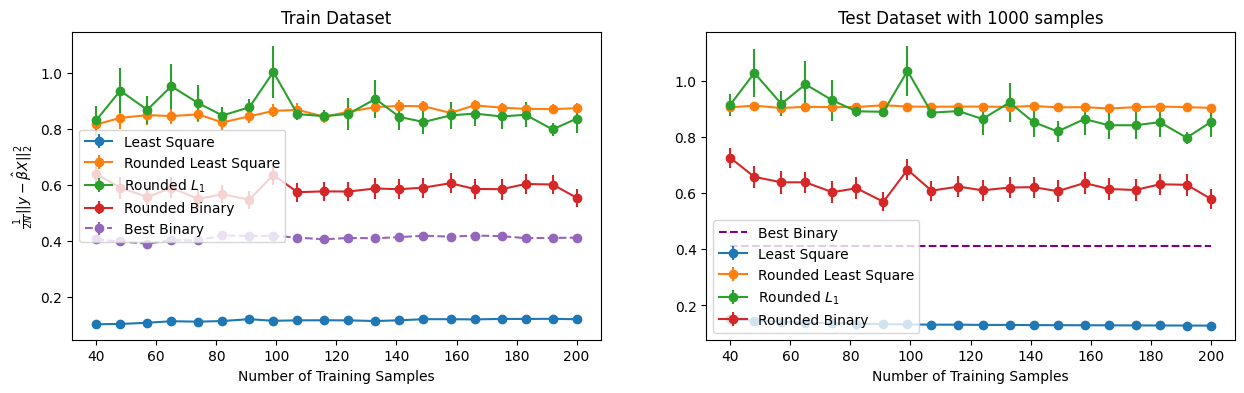

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].errorbar(sample_size, x7_ls_train_mean_sse_per_size, yerr=np.array(x7_ls_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o',  label='Least Square')
axs[0].errorbar(sample_size, x7_rls_train_mean_sse_per_size, yerr=np.array(x7_rls_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Least Square')
axs[0].errorbar(sample_size, x7_l1_train_mean_sse_per_size, yerr=np.array(x7_l1_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded $L_1$')
axs[0].errorbar(sample_size, x7_binary_train_mean_sse_per_size, yerr=np.array(x7_binary_train_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Binary')
axs[0].errorbar(sample_size, x7_best_binary_mean_train_sse_per_size, yerr=np.array(x7_best_binary_std_train_sse_per_size)*1.96/(n_repitition**0.5),linestyle='--', marker='o', label='Best Binary')
axs[0].set_xlabel('Number of Training Samples')
axs[0].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[0].set_title('Train Dataset')
axs[0].legend()

axs[1].errorbar(sample_size, x7_ls_test_mean_sse_per_size, yerr=np.array(x7_ls_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o',  label='Least Square')
axs[1].errorbar(sample_size, x7_rls_test_mean_sse_per_size, yerr=np.array(x7_rls_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Least Square')
axs[1].errorbar(sample_size, x7_l1_test_mean_sse_per_size, yerr=np.array(x7_l1_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded $L_1$')
axs[1].errorbar(sample_size, x7_binary_test_mean_sse_per_size, yerr=np.array(x7_binary_test_std_sse_per_size)*1.96/(n_repitition**0.5), marker='o', label='Rounded Binary')
axs[1].hlines(x7_best_binary_sse_test, min(sample_size), max(sample_size), linestyle='--',color='purple', label='Best Binary')
axs[1].set_xlabel('Number of Training Samples')
# axs[1].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[1].set_title('Test Dataset with 1000 samples')
axs[1].legend()


In [28]:
import itertools

all_answer_lst = list(itertools.product([0, 1], repeat=7))

for pa in all_answer_lst:
    nn = len([res for res in x7_binary_rounded_beta_hat_per_iter if tuple(res)==pa])
    if nn!=0:
        print(f'Rounded Binary: {pa} --> {nn}')
print()
for pa in all_answer_lst:
    nn = len([res for res in x7_rls_beta_hat_per_iter if tuple(res)==pa])
    if nn!=0:
        print(f'Rounded Least Square: {pa} --> {nn}')
print()
for pa in all_answer_lst:
    nn = len([res for res in x7_best_binary_beta_hat_per_iter if tuple(res)==pa])
    if nn!=0:
        print(f'Best Binary: {pa} --> {nn}')




Rounded Binary: (0, 0, 0, 0, 0, 0, 1) --> 6
Rounded Binary: (0, 0, 0, 0, 0, 1, 1) --> 39
Rounded Binary: (0, 0, 1, 0, 0, 0, 0) --> 1
Rounded Binary: (0, 0, 1, 0, 0, 1, 0) --> 20
Rounded Binary: (0, 0, 1, 1, 0, 1, 0) --> 10
Rounded Binary: (0, 1, 0, 0, 0, 0, 1) --> 3
Rounded Binary: (1, 0, 0, 0, 0, 0, 1) --> 5
Rounded Binary: (1, 0, 1, 0, 0, 0, 0) --> 2
Rounded Binary: (1, 0, 1, 1, 0, 0, 0) --> 4
Rounded Binary: (1, 1, 0, 0, 0, 0, 1) --> 4
Rounded Binary: (1, 1, 1, 0, 0, 0, 0) --> 4
Rounded Binary: (1, 1, 1, 1, 0, 0, 0) --> 2

Rounded Least Square: (0, 0, 1, 0, 0, 0, 0) --> 29
Rounded Least Square: (0, 0, 1, 1, 0, 0, 0) --> 15
Rounded Least Square: (0, 1, 1, 0, 0, 0, 0) --> 9
Rounded Least Square: (0, 1, 1, 1, 0, 0, 0) --> 3
Rounded Least Square: (1, 0, 1, 0, 0, 0, 0) --> 11
Rounded Least Square: (1, 0, 1, 1, 0, 0, 0) --> 1
Rounded Least Square: (1, 1, 1, 0, 0, 0, 0) --> 22
Rounded Least Square: (1, 1, 1, 1, 0, 0, 0) --> 10

Best Binary: (0, 0, 0, 0, 0, 1, 1) --> 97
Best Binary: (0, 0, 

In [32]:
# x,y,w = DataGenerator(n_samples=100, n_features=5, random_state=None)

# loss = np.zeros([len(w),2])+np.infty
# w_hat_branch = np.empty([len(w),2], dtype=object)
# # loss_one = np.zeros(len(w))+np.infty
# w_hat = leastsquare(x,y)
# w_i = 0
# flag = False
# while(w_i!=len(w)+1):
    
#     w_hat[w_i] = 0
#     w_hat_branch[w_i, 0] = w_hat.copy()
#     loss[w_i,0] = squared_error(w_hat, x, y)

#     w_hat[w_i] = 1
#     w_hat_branch[w_i, 1] = w_hat.copy()
#     loss[w_i,1] = squared_error(w_hat, x, y)
    
#     min_loss_ind = np.unravel_index(loss.argmin(), loss.shape)
#     w_hat = w_hat_branch[min_loss_ind]
#     print(min_loss_ind)
    
#     if min_loss_ind[0]>=w_i:
#         w_i = w_i + 1
#         flag = False

#     else:
#         w_i = min_loss_ind[0]+1
#         flag = True

In [33]:

    # for i, w_i in enumerate(w_hat):
    #     w_hat[i] = 0
    #     loss_zero = squared_error(w_hat, x, y)
    #     w_hat[i] = 1
    #     loss_one = squared_error(w_hat, x, y)
    #     if loss_one < loss_zero:
    #         w_hat[i] = 1
    #     else:
    #         w_hat[i] = 0
    # w_hat_per_brn.append(w_hat)